#Consts

In [0]:
base_dir = 'drive/My Drive/biocell_dataset/'
weights_file_name = 'outputunet_biocell_v2_50epochs.hdf5'

# image_path = '/biocell/train/images/ffefcc2a-ea46-4dd0-b02f-b9b663c99c8d.png'
# image_path = '/biocell/train/images/9b544d95-5c6a-4ec8-a6a5-45b13ef9a630.png'
image_path = 'real_images_for_prediction/r02c03f24p01-ch4sk1fk1fl1.tiff'

imgs_titles = ['BACKGROUND', 'LAYER_1', 'LAYER_2', 'BOTH']

# Imports etc.

In [0]:
import numpy as np 
import os
import skimage.io as io
import io as pio
import skimage.transform as trans
import skimage
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras import utils
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [4]:
print(tf.__version__)
print(tf.keras.__version__)

2.2.0
2.3.0-tf


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Model definition

In [0]:
def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(4, 1, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model


# Helper functions

In [0]:
def adjustData(img):
    # img = img / np.max(img)
    img = img / (2**16 - 1.0)
    return img

def tempFixSize(img, label=False):
    return img[:,30:542,30:542]

def load_trained_model(weights_path):
   model = unet()
   model.load_weights(weights_path)
   return model

In [0]:
def plot_images2(title, images, titles=imgs_titles):
  # Create a figure to contain the plot.
  figure = plt.figure(figsize=(len(images), 1), dpi=512)
  for index in range(len(images)):
      # Start next subplot.
      plt.subplot(1, len(images), index + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.xlabel(titles[index], fontsize=4)
      plt.imshow(images[index], cmap='gray')

In [0]:
def plot_images(title, images, titles=imgs_titles):
  # Create a figure to contain the plot.
  fig, axs = plt.subplots(1, len(images), figsize=(20, 10))
  for index in range(len(images)):
      axs[index].imshow(images[index], cmap='gray')
      axs[index].title.set_text(titles[index])

# Image & weights loading + prediction & plotting

(1, 512, 512)


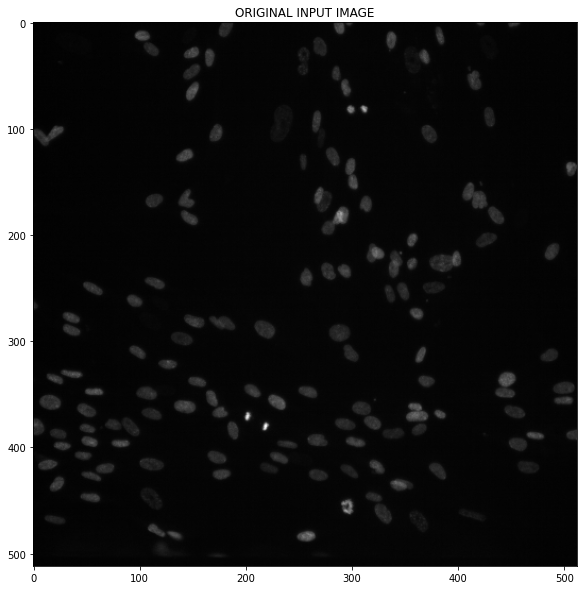

In [10]:
dim = (572,572)
input_img = np.empty((1, *dim))

input_img[0,] = io.imread(base_dir + image_path, as_gray=True)
input_img = adjustData(input_img)
input_img = tempFixSize(input_img)

print (input_img.shape)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(input_img[0], cmap='gray')
ax.title.set_text('ORIGINAL INPUT IMAGE')

In [11]:
print(f'max: {np.max(input_img)}')
print(f'min: {np.min(input_img)}')
print(f'mean: {np.mean(input_img)}')
print(f'median: {np.median(input_img)}')

max: 0.08003356984817273
min: 0.0015716792553597315
mean: 0.004123398796902867
median: 0.0030975814450293735


In [12]:
model = load_trained_model(base_dir + weights_file_name)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [13]:
outputs = model.predict(input_img, verbose=0)
prediction = outputs[0]
prediction.shape

(512, 512, 4)

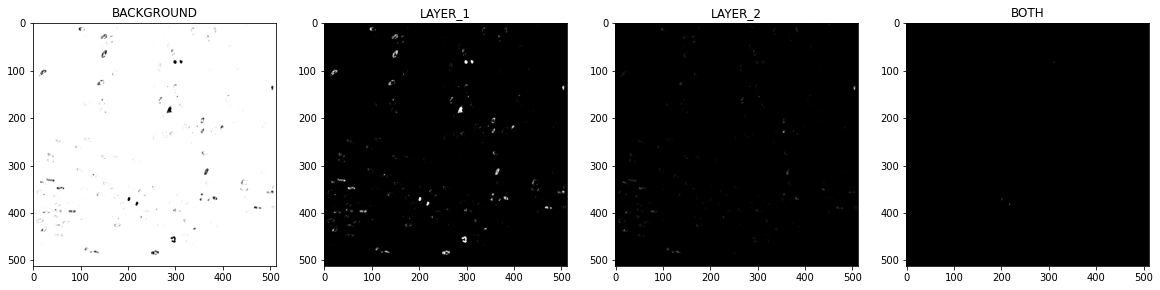

In [14]:
background = prediction[:,:,0]
layer_1 = prediction[:,:,1]
layer_2 = prediction[:,:,2]
both = prediction[:,:,3]

plot_images("PREDICTION OF THE DIFFERENT LAYERS",[background, layer_1, layer_2, both])

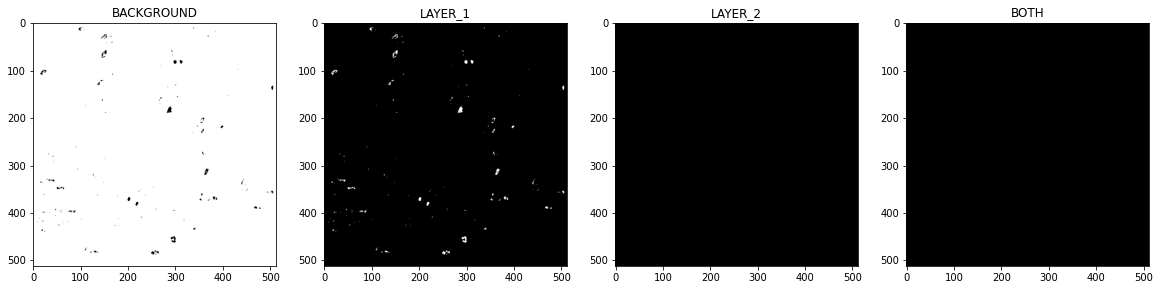

In [15]:
argmaxed = tf.argmax(prediction, axis=-1)

background_mask = np.where(argmaxed == 0, 1, 0)
layer_1_mask = np.where(argmaxed == 1, 1, 0)
layer_2_mask = np.where(argmaxed == 2, 1, 0)
both_mask = np.where(argmaxed == 3, 1, 0)

plot_images("PREDICITON AFTER ARGMAX", [background_mask, layer_1_mask, layer_2_mask, both_mask])

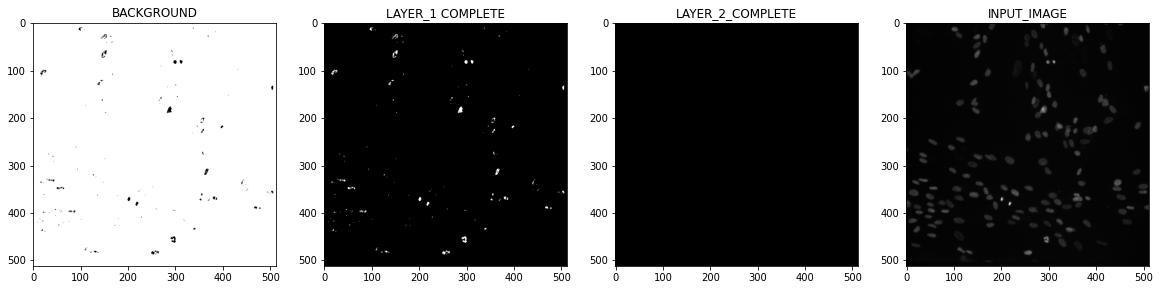

In [16]:
layer_1_complete = layer_1_mask + both_mask
layer_2_complete = layer_2_mask + both_mask

plot_images("COMPLETED CELLS", [background_mask, layer_1_complete, layer_2_complete, input_img[0]], ['BACKGROUND', 'LAYER_1 COMPLETE', 'LAYER_2_COMPLETE', 'INPUT_IMAGE'])

#Boundries and counting

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters
from skimage.segmentation import flood, flood_fill, find_boundaries
from skimage.morphology import area_opening, area_closing

In [0]:
def find_count(image):
  counter = 2
  result = np.argwhere(image == 1)
  axis0, axis1 = result.shape
  result_filled = area_opening(image, area_threshold=50)

  while not axis0 == 0:
    x = result[0][0]
    y = result[0][1]
    result_filled = flood_fill(result_filled, (x,y), counter)
    counter = counter + 1
    result = np.argwhere(result_filled == 1)
    axis0, axis1 = result.shape
  
  return counter - 1

def boundries_image(image, r, g, b):
  boundries = find_boundaries(area_opening(image, area_threshold=50))
  result_image = np.zeros((image.shape[0], image.shape[1], 3))
  result_image[:,:,0] = np.where(boundries, r, 0)
  result_image[:,:,1] = np.where(boundries, g, 0)
  result_image[:,:,2] = np.where(boundries, b, 0)
  return result_image.astype(int)

In [0]:
layer_1_cell_count = find_count(layer_1_complete)
layer_2_cell_count = find_count(layer_2_complete)
no_overlap_detection_cell_count = find_count(np.where(background_mask == 1, 0, 1))

In [20]:
print(f"number of cells in layer_1: {layer_1_cell_count}")
print(f"number of cells in layer_2: {layer_2_cell_count}")
print(f"number of cells before overlap detection: {no_overlap_detection_cell_count}")
print(f"diff: {layer_1_cell_count + layer_2_cell_count - no_overlap_detection_cell_count}")

number of cells in layer_1: 6
number of cells in layer_2: 1
number of cells before overlap detection: 6
diff: 1


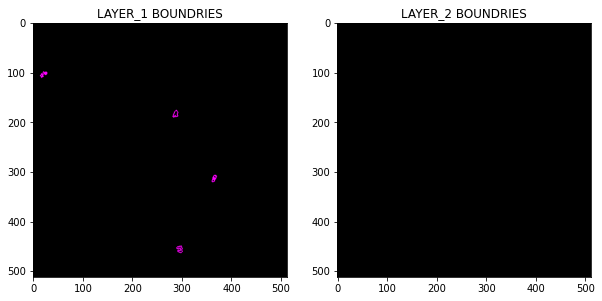

In [21]:
layer_1_boundries = boundries_image(layer_1_complete, 255,0,255)
layer_2_boundries = boundries_image(layer_2_complete, 0,255,255)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(layer_1_boundries)
axs[0].title.set_text('LAYER_1 BOUNDRIES')
axs[1].imshow(layer_2_boundries)
axs[1].title.set_text('LAYER_2 BOUNDRIES')

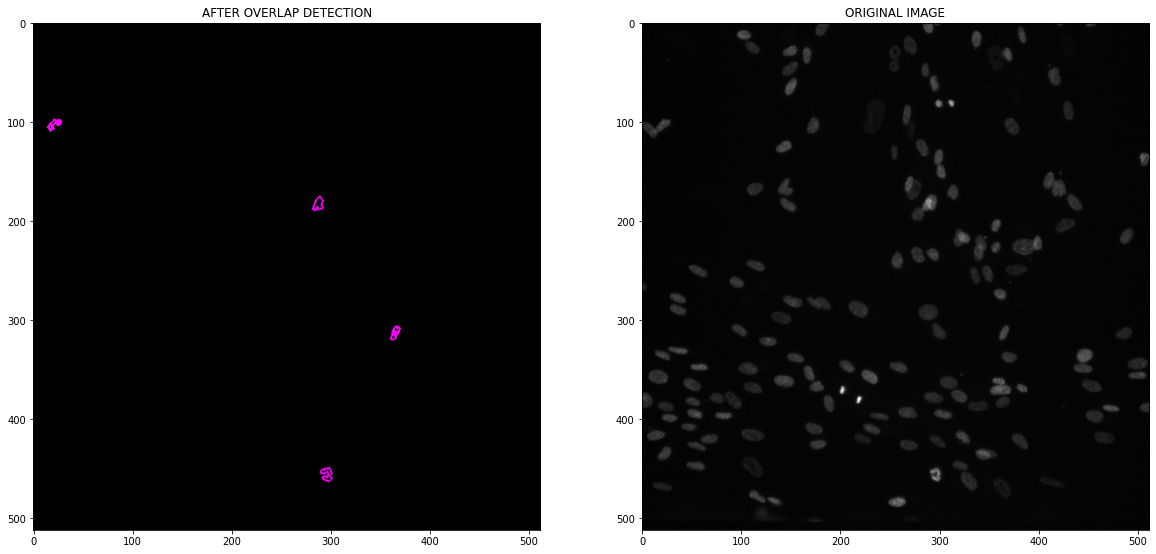

In [22]:
combined = (layer_1_boundries + layer_2_boundries)

fig, axs = plt.subplots(1,2,figsize=(20, 20))
axs[0].imshow(combined)
axs[0].title.set_text('AFTER OVERLAP DETECTION')
axs[1].imshow(input_img[0], cmap='gray')
axs[1].title.set_text('ORIGINAL IMAGE')